# Nonadiabatic dynamics based on exact factorization in Libra


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Theoretical Background](#2)

   2.1. [Decoherence-Induced Surface Hopping based on XF (DISH-XF) or SHXF](#2.1)

3. [Model Hamiltonians](#3)

4. [Choosing the Nonadiabatic Dynamics Methodology](#4)

5. [Choosing initial conditions: Nuclear and Electronic](#5)

6. [Running the calculations](#6)

7. [Plotting the results](#7)

8. [Comparison with quantum dynamics](#8)


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries, set up some definitions (e.g. colors), and define the function that would be calling model Hamiltonians also defined within Libra package.

Packages that set dynamic parameters are imported from the recipes directory. Their names specify their corresponding nonadiabatic dynamics methods. Specifically, nonadiabatic dynamics methods based on exact factorization (XF) contain 'xf' in their names. Try to run other methods for comparison.

    from recipes import shxf
    from recipes import ehrenfest_adi_ld, ehrenfest_dia, mfsd
    from recipes import fssh, sdm, bcsh

In [1]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
import libra_py.models.Holstein as Holstein
import libra_py.models.Tully as Tully
import libra_py.models.Subotnik as Subotnik
import libra_py.models.Esch_Levine as Esch_Levine
from libra_py import dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers

from recipes import shxf
from recipes import ehrenfest_adi_ld, ehrenfest_dia, mfsd
from recipes import fssh, sdm, bcsh

import libra_py.dynamics.exact.compute as dvr
import libra_py.dynamics.exact.save as dvr_save

#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/dhhan/conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/dhhan/conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/dhhan/conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<float> >

## 2. Theoretical Background
<a name="2"></a>[Back to TOC](#TOC)

XF is a wave function ansatz in which the total wave function is separated into a nuclear wave function and its conditional electronic wave function, represented as:

$$\Psi(\mathbf{r},\mathbf{R},t)=\chi(\mathbf{R},t)\Phi_{\mathbf{R}}(\mathbf{r},t)$$

Based on XF, the mixed quantum-classical (MQC) equations have been formulated for trajectory-based nonadiabatic dynamics:  
$$ i\hbar \frac{d}{dt}\Phi_{\mathbf{R}}(\mathbf{r},t)= \left[ H_{BO}(\mathbf{r};\mathbf{R})+\sum_{\nu}\frac{-i\mathcal{P}_{\nu}}{M_{\nu}}\cdot (\mathbf{A}_{\nu}+i\hbar \nabla_{\nu}) \right]\Phi_{\mathbf{R}}(\mathbf{r},t) $$

$$ \mathbf{F}_{\nu}=-\langle \Phi_{\mathbf{R}}|\nabla_{\nu}\hat{H}_{BO}|\Phi_{\mathbf{R}}\rangle_{\mathbf{r}}+\sum_{\nu'}\frac{-2\mathcal{P}_{\nu'}}{\hbar M_{\nu'}}\cdot\left(\mathbf{A}_{\nu'}\mathbf{A}_{\nu}-\hbar^{2} \Re \langle \nabla_{\nu'}\Phi_{\mathbf{R}}(t)|\nabla_{\nu}\Phi_{\mathbf{R}}(t)\rangle_{\mathbf{r}}\right)$$

Beyond the conventional Ehrenfest terms, additional terms—constructed using the time-dependent vector potential $\mathbf{A}_{\nu}$ and  quantum momentum $\mathcal{P}_{\nu}$—explicitly describe the electron-nuclear correlation. $\mathbf{A}_{\nu}$ and $\mathcal{P}_{\nu}$ are defined as

$$ \mathbf{A}_{\nu}(\mathbf{R},t)=\langle \Phi_{\mathbf{R}}(t)|-i\hbar \nabla_{\nu} \Phi_{\mathbf{R}}(t)\rangle_{\mathbf{r}} $$

$$ \mathcal{P}(\mathbf{R},t) = - \frac{\hbar \nabla_{\nu}|\chi(\mathbf{R},t)|^{2}}{2|\chi(\mathbf{R},t)|^{2}} $$

As the quantum momentum contains the information of the nuclear wave function, the quantum momentum needs to be approximated under the trajectory-based approximation.  To propagate MQC equations, one can use either the coupled-trajectory or the independent-trajectory approach. In the coupled-trajectory approach, a swarm of trajectories is propagated simultaneously, imitating the overall nuclear distribution. Conversly, in the indenpendent-trajectory approach, the propagation of electrons and nuclei is done under a single trajectory, and interactions from other trajectories are indirectly considered through the use of fictitious auxiliary trajectories. 

XF-based nonadiabatic dynamics methods are categorized based on the use of trajectories and the level of theory of the classical force.

|  |Surface Hopping|Ehrenfest|MQC
:---:|:---:|:---:|:---:
**Independent Trajectory**|DISH-XF (SHXF)|EhXF|MQCXF
**Coupled Trajectory**|CTSH|CTMQCe| CTMQC|

### 2.1 Decoherence-Induced Surface Hopping based on XF (DISH-XF) or SHXF
<a name="2.1"></a>[Back to TOC](#TOC)

 * `shxf` - this recipe defines the decoherence-induced surface hopping based on XF (DISH-XF) or SHXF method of Ha and Min:
 
   Ha, J.-K.; Lee, I. S.; Min, S. K. Surface Hopping Dynamics beyond Nonadiabatic Couplings for Quantum Coherence. *J. Phys. Chem. Lett.* **2018**, 9, 1097. https://doi.org/10.1021/acs.jpclett.8b00060.

In the SHXF dynamics, the nuclear propagation follows the conventional surface hopping procedure, thus 

    dyn_general.update({"tsh_method":0 })

The electronic propagation follows the electronic MQC equation, conducted in the adiabatic representation. The differential equation for adiabatic coefficients $C_{k}^{(I)}$ of the $I$th trajectory is given as

$$ \dot C^{(I)}_k(t) = -\frac{i}{\hbar}E^{(I)}_k(t)C^{(I)}_k(t)- \sum_j\sum_\nu{\bf d}^{(I)}_{kj\nu}(t)\cdot\dot{\bf R}^{(I)}_\nu(t)C^{(I)}_j(t) -\sum_j\sum_\nu\frac{\mathcal{P}_{\nu}(\mathbf{R}^{(I)},t)}{M_\nu} \cdot\left\{{\bf f}^{(I)}_{j\nu}(t)-{\bf f}^{(I)}_{k\nu}(t)\right\}|C^{(I)}_j(t)|^2 C^{(I)}_k(t) $$

The quantum momentum is calculated by approximating each nuclear adibatic wavepacket to a Gaussian function.
$$ |\chi|^2 = \sum_{k}|\chi_{k}|^2 = \sum_{k}N_{k}\prod_\nu
         \exp\left(-\dfrac{|\textbf{R}^{(I)}_\nu-\textbf{R}_{k,\nu}|^2}{2\sigma^2_{\nu}}\right). $$
The parameter for this width of a wavepacket corresponds to `dyn_general["wp_width"]`. The position of each adiabatic wave packet, $\textbf{R}_{k}$ is also estimated by propagating auxiliary trajectories. An auxiliary trajectories for the $k$th state is generated when its population becomes numerically finite, i.e., $\epsilon< |C_{k}^{(I)}|^{2}< 1-\epsilon$. This threshold $\epsilon$ is also a parameter, `dyn_general["coherence_threshold"]`. After the creation of each auxiliary trajectory, its evolution is conducted by uniform velocity from the energy conservation:

$$ \sum_{\nu}\frac{1}{2}M_{\nu}\dot{\mathbf{R}}_{k\nu}^{(I)2}(t)= \sum_{\nu}\frac{1}{2}M_{\nu}\dot{\mathbf{R}}_{\nu}^{(I)2}(t)+E^{(I)}(t)-E_{k}^{(I)}(t)$$

While auxiliary trajectories are propagated in the interval $[t_{0}, t]$, the spatial derivative of phase $\mathbf{f}_{k\nu}^{(I)}$ is computed by the change of momentum:
$$ \mathbf{f}_{k\nu}^{(I)} = -\int_{t_{0}}^{t} \nabla_{\nu}E_{k}^{(I)}(\tau) d\tau \approx M_{\nu}\dot{\mathbf{R}}_{k\nu}^{(I)}(t) - M_{\nu}\dot{\mathbf{R}}_{k\nu}^{(I)}(t_{0}) $$

### 2.2 Mixed Quantum-Classical based on XF (MQCXF)


## 3. Model Hamiltonians
<a name="3"></a>[Back to TOC](#TOC)

First, let's define the `compute_model` function that returns all the necessary objects and properties for the dynamics. 

In [2]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:        
        res = Holstein.Holstein2(q, params, full_id) 
    elif model==2:
        res = Tully.Tully3(q, params, full_id)
    elif model==3:
        res = Subotnik.double_arch_geometry(q, params, full_id)
    elif model==4:
        res = Esch_Levine.JCP_2020(q, params, full_id)
    else:
        pass            

    return res

Here, we define several sets of parameters:

* Sets 1 to 4 - for the 2-level Holstein Hamiltonians. These are just parabolas with constant coupling.
* Sets 5 - for the ECWR (Extended Coupling With Reflection) Tully model
* Sets 6 - for the DAG (Double Arch Geometry) or symmetrized ECWR Tully model
* Sets 7 to 10 - for the n-level Esch-Levine Hamiltonians. These are just lines or bundles of lines crossing with yet another line and having a constant coupling. These models are for 2- to 5-state problems. 

In [3]:
model_params1 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.000}
model_params2 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.001}
model_params3 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.01}
model_params4 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0, -0.01], "x_n":[0.0,  0.5],"k_n":[0.002, 0.008],"V":0.001}

model_params5 = {"model":2, "model0":2, "nstates":2} # ECR
model_params6 = {"model":3, "model0":3, "nstates":2} # DAG

model_params7 = {"model":4, "model0":4, "nstates":2, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":2, "delta":0.01 } # Esch-Levine

model_params8 = {"model":4, "model0":4, "nstates":3, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":3, "delta":0.01 } # Esch-Levine

model_params9 = {"model":4, "model0":4, "nstates":5, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":4, "delta":0.01 } # Esch-Levine

model_params10 = {"model":4, "model0":4, "nstates":5, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.02, "i_crit":3, "delta":0.01 } # Esch-Levine

all_model_params = [model_params1, model_params2, model_params3, model_params4, 
                    model_params5, model_params6, 
                    model_params7, model_params8, model_params9, model_params10
                   ]

Choose the model to simulate here by setting `model_indx`.

In [4]:
# 0 - Holstein, trivial crossing, 2 level
# 1 - Holstein, strong nonadiabatic, 2 level
# 2 - Holstein, adiabatic, 2 level
# 3 - Holstein, double crossing, strong nonadiabatic, 2 level
# 4 - Tully, extended crossing with reflection, 2 level
# 5 - Double arch geometry or symmetrized ECWR, 2 level
# 6 - Esch-Levine, LZ-like, 2 level
# 7 - Esch-Levine, 1 crosses 2 parallel, 3 level
# 8 - Esch-Levine, 1 crosses 4 evenly-spaced parallel, 5 level
# 9 - Esch-Levine, 1 crosses 4 parallel split into 2 groups, 5 level

#################################
# Give the model used an index
model_indx = 5
################################

model_params = all_model_params[model_indx]

Here, visualization of each model system is done. Change parameters accordingly.

In [5]:
# New plotting:
# Common setups
plot_params = {"figsize":[24, 6], "titlesize":24, "labelsize":28, "fontsize": 28, "xticksize":26, "yticksize":26,
               "colors": colors, "clrs_index": clrs_index,
               "prefix":F"case", "save_figures":0, "do_show":1,
               "plotting_option":1, "nac_idof":0 }


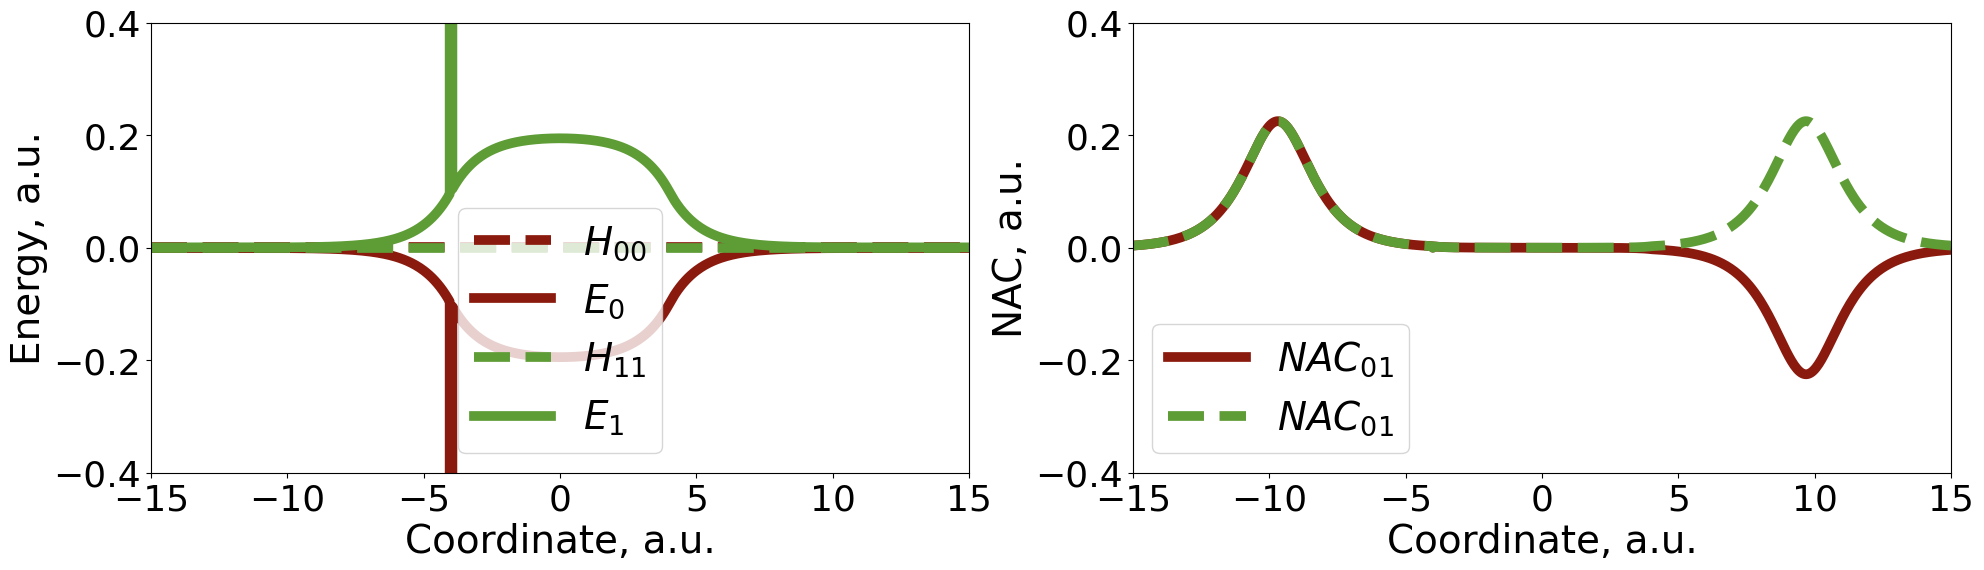

In [6]:
list_states = [x for x in range(model_params["nstates"])]

# Holstein
#plot_params.update( { "xlim":[-1, 5], "ylim":[-0.01, 0.03], "ylim2":[-2, 2], "show_nac_abs":1 })
#dynamics_plotting.plot_surfaces(compute_model, [ model_params ], list_states, -4.0, 5.0, 0.05, plot_params)

# Tully
plot_params.update( { "xlim":[-15.0, 15.0], "ylim":[-0.4, 0.4], "ylim2":[-0.4, 0.4], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params ], list_states, -15.0, 15.0, 0.05, plot_params)

# Esch-Levine
#plot_params.update( { "xlim":[-4, 8], "ylim":[-0.06, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
#dynamics_plotting.plot_surfaces(compute_model, [ model_params ], list_states, -4.0, 8.0, 0.05, plot_params)

## 4. Choosing the Nonadiabatic Dynamics Methodology 
<a name="4"></a>[Back to TOC](#TOC)

In this section, we go over parameters to set up a computational methodology. 

Let's start with the simulation-specific parameters:

* `nsteps` -  how many steps of dynamics to compute
* `nstaj` - how many trajectories to use
* `nstates:2` - all our models are 2-level systems
* `dt:1` - nuclear integration timestep in a.u. of time
* `num_electronic_substeps` - do multiple steps of electronic integration per nuclear step
* `isNBRA` and `is_nbra` - is set to `1`, will turn on some simplifications and optimization for NBRA type of calculations. Here, we are doing the non-NBRA case
* `frogress_frequency:0.1` - printing out a message evry `2500 x 0.1 = 250` steps
* `which_adi_states` - properties of which adiabatic states to save, we only have 2
* `which_dia_states` - properties of which diabatic states to save, we only have 2
* `mem_output_level:4` - how much data to save into the hdf5 output files. This is the most intensive output, usually needed only for some special cases (extra-analysis, debugging, new methods, demonstration like htis, etc.)
* `properties_to_save` - list of properties to be computed on the fly and saved into hdf5 output file.

In [7]:
# For setting nsteps
list_nsteps = []
for i in range(len(all_model_params)):
    if all_model_params[i]["model"] == 1: #Holstein
        list_nsteps.append(25000)
    elif all_model_params[i]["model"] == 2: #ECR
        list_nsteps.append(4000)
    elif all_model_params[i]["model"] == 3: #DAG
        list_nsteps.append(3000)
    elif all_model_params[i]["model"] == 4: #Esch-Levine
        list_nsteps.append(25000)

In [8]:
NSTATES = model_params["nstates"]

dyn_general = { "nsteps":list_nsteps[model_indx], "ntraj":25, "nstates":NSTATES,
                "dt":1.0, "num_electronic_substeps":1, "isNBRA":0, "is_nbra":0,
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),      
                "mem_output_level":3,
                "properties_to_save":[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
                "se_pop_adi", "se_pop_dia", "sh_pop_adi"],
                "prefix":"adiabatic_md", "prefix2":"adiabatic_md"
              }

#[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
#                "se_pop_adi", "se_pop_dia", "sh_pop_adi", "hvib_adi", "hvib_dia", "St", "basis_transform", "D_adi" ]

Now, it is time to select the type of calculations we want to do. Keep in mind that some options are related to each other, so usually one would need to correlate the choices. For methods based on surface hopping, default options are used for frustrated hops and how to rescale momenta on hops.

In [9]:
#################################
# Give the recipe above an index
method_indx = 7
#################################

if method_indx == 0:
    ehrenfest_dia.load(dyn_general)  # Ehrenfest, dia
elif method_indx == 1:
    ehrenfest_adi_nac.load(dyn_general)  # Ehrenfest, adi with NACs    
elif method_indx == 2:
    ehrenfest_adi_ld.load(dyn_general)  # Ehrenfest, adi with LD
elif method_indx == 3:
    mfsd.load(dyn_general)  # MFSD
    
elif method_indx == 4:
    fssh.load(dyn_general)  # FSSH
elif method_indx == 5:
    sdm.load(dyn_general)  # SDM with default EDC parameters
elif method_indx == 6:
    bcsh.load(dyn_general)  # BCSH 

elif method_indx == 7:
    shxf.load(dyn_general)  # SHXF 

## 5. Choosing initial conditions: Nuclear and Electronic
<a name="5"></a>[Back to TOC](#TOC)

The setup of the parameters below is rather intuitive:

* `ndof` - number of nuclear degrees of freedom
* `q` - nuclear coordinates, should be of length `ndof`
* `p` - nuclear momenta, should be of length `ndof`
* `mass` - nuclear masses, should be of length `ndof`
* `force_constant` - should be of length `ndof`; this is the force constant of the harmonic potential that defines the width of the Gaussian wavepacket (that is the ground-state solution for such potential)
* `init_type` - how to sample (or not) momenta and coordinates

For electronic variables:
* `ndia` - the number of diabatic states
* `nadi` - the number of adiabatic states
* `rep` - representation in which we initialize the electronic variables:
  - 0 - diabatic wfc;
  - 1 - adiabatic wfc;
  - 2 - diabatic density matrix;
  - 3 - adiabatic density matrix;
* `istates` - the populations of all `rep` states, should be of length `nadi`
* `init_type` - how to sample amplitudes

In [10]:
#*********************** This is for the initial condition type **************************
#============== How nuclear DOFs are initialized =================
#icond_nucl = 0  # Coords and momenta are set exactly to the given value
#icond_nucl = 1  # Coords are set, momenta are sampled
#icond_nucl = 2  # Coords are sampled, momenta are set
icond_nucl = 3  # Both coords and momenta are sampled

nucl_params = { "ndof":1, "q":[-4.0], "p":[0.0], 
                "mass":[2000.0], "force_constant":[0.01], 
                "init_type":icond_nucl }

#============= How electronic DOFs are initialized ==================
#icond_elec = 2  # amplitudes all have the same phase
icond_elec = 3  # amplitudes gain random phase 

#============= Also select the representation ========================
# rep = 0 # diabatic wfc
rep = 1 # adiabatic wfc

istates = []
for i in range(NSTATES):
    istates.append(0.0)    
    
elec_params = {"verbosity":2, "init_dm_type":0,
               "ndia":NSTATES, "nadi":NSTATES, 
               "rep":rep, "init_type":icond_elec, "istates":istates
              }

#******************** This is for specific values in initial conditions *******************
#####################################
# Select a specific initial condition
icond_indx = 0
#####################################    

if model_indx in [0, 1]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][1] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-1.0]
        elec_params["istates"][0] = 1.0 
elif model_indx in [2]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][1] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-2.0]
        elec_params["istates"][0] = 1.0 
elif model_indx in [3]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][1] = 1.0
    elif icond_indx==1:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][0] = 1.0
elif model_indx in [4]: # Tully, ECR
    if icond_indx==0:
        nucl_params["q"] = [-15.0]
        nucl_params["p"] = [25.0]
        elec_params["istates"][0] = 1.0
elif model_indx in [5]: # Tully, DAG
    if icond_indx==0:
        nucl_params["q"] = [-20.0]
        nucl_params["p"] = [20.0]
        elec_params["istates"][0] = 1.0
elif model_indx in [6]: # Esch-Levine 2-level
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][1] = 1.0
elif model_indx in [7]: # Esch-Levine 3-level
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][2] = 1.0
elif model_indx in [8,9]: # Esch-Levine 5-level, two types
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][4] = 1.0

## 6. Running the calculations
<a name="6"></a>[Back to TOC](#TOC)

In [11]:
%%time

dyn_params = dict(dyn_general)
dyn_params.update({ "prefix":F"model{model_indx}-method{method_indx}-icond{icond_indx}", 
                    "prefix2":F"model{model_indx}-method{method_indx}-icond{icond_indx}" })

print(F"Computing model{model_indx}-method{method_indx}-icond{icond_indx}")    

rnd = Random()
res = tsh_dynamics.generic_recipe(dyn_params, compute_model, model_params, elec_params, nucl_params, rnd)

Computing model5-method7-icond0
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
se

 step= 300
 step= 600
metersUse the default value 
In cctor: lvl = 1 der_lvl = 2
destroy auxiliary trajectories 13
 step= 900
destroy auxiliary trajectories 23
destroy auxiliary trajectories 5
destroy auxiliary trajectories 0
destroy auxiliary trajectories 14
destroy auxiliary trajectories 17
destroy auxiliary trajectories 20
destroy auxiliary trajectories 15
destroy auxiliary trajectories 7
 step= 1200
destroy auxiliary trajectories 10
destroy auxiliary trajectories 9
destroy auxiliary trajectories 11
destroy auxiliary trajectories 20
 step= 1500
 step= 1800
 step= 2100
destroy auxiliary trajectories 6
 step= 2400
destroy auxiliary trajectories 7
destroy auxiliary trajectories 8
destroy auxiliary trajectories 9
destroy auxiliary trajectories 0
 step= 2700
destroy auxiliary trajectories 20
destroy auxiliary trajectories 3
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi'

## 7. Plotting the results
<a name="7"></a>[Back to TOC](#TOC)

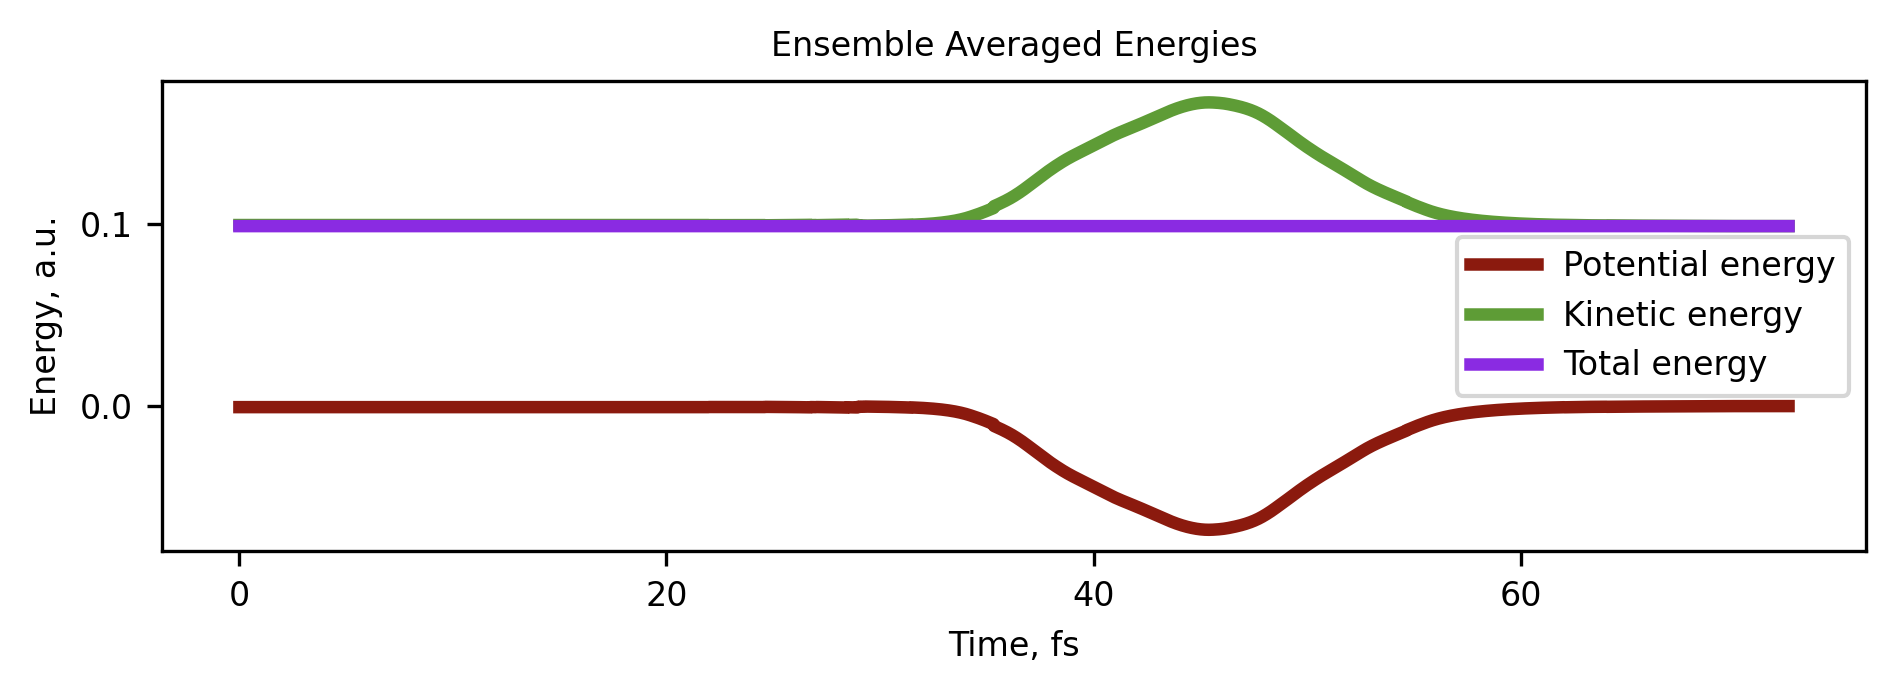

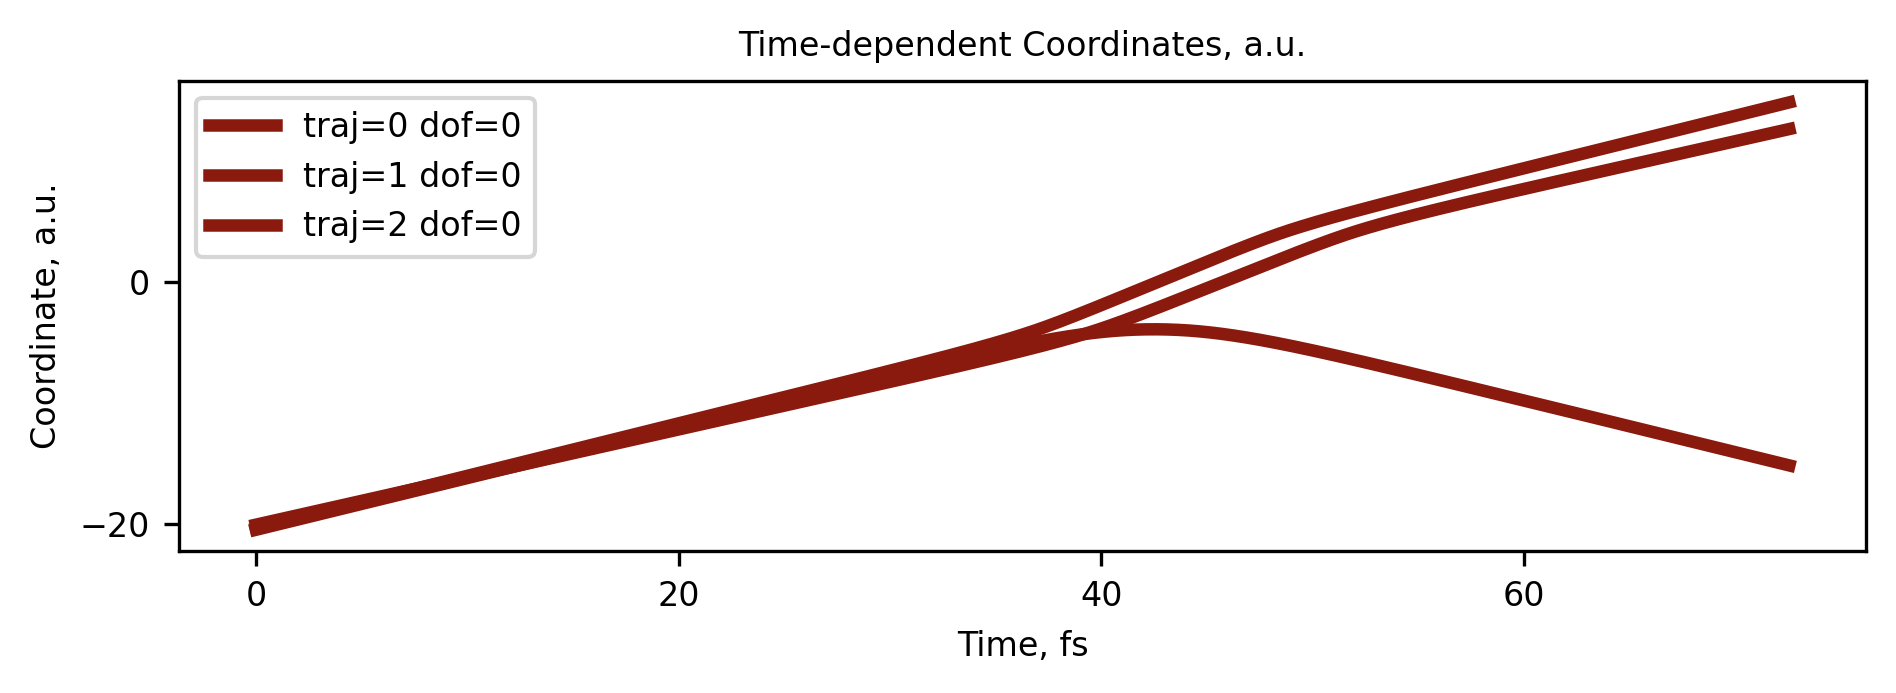

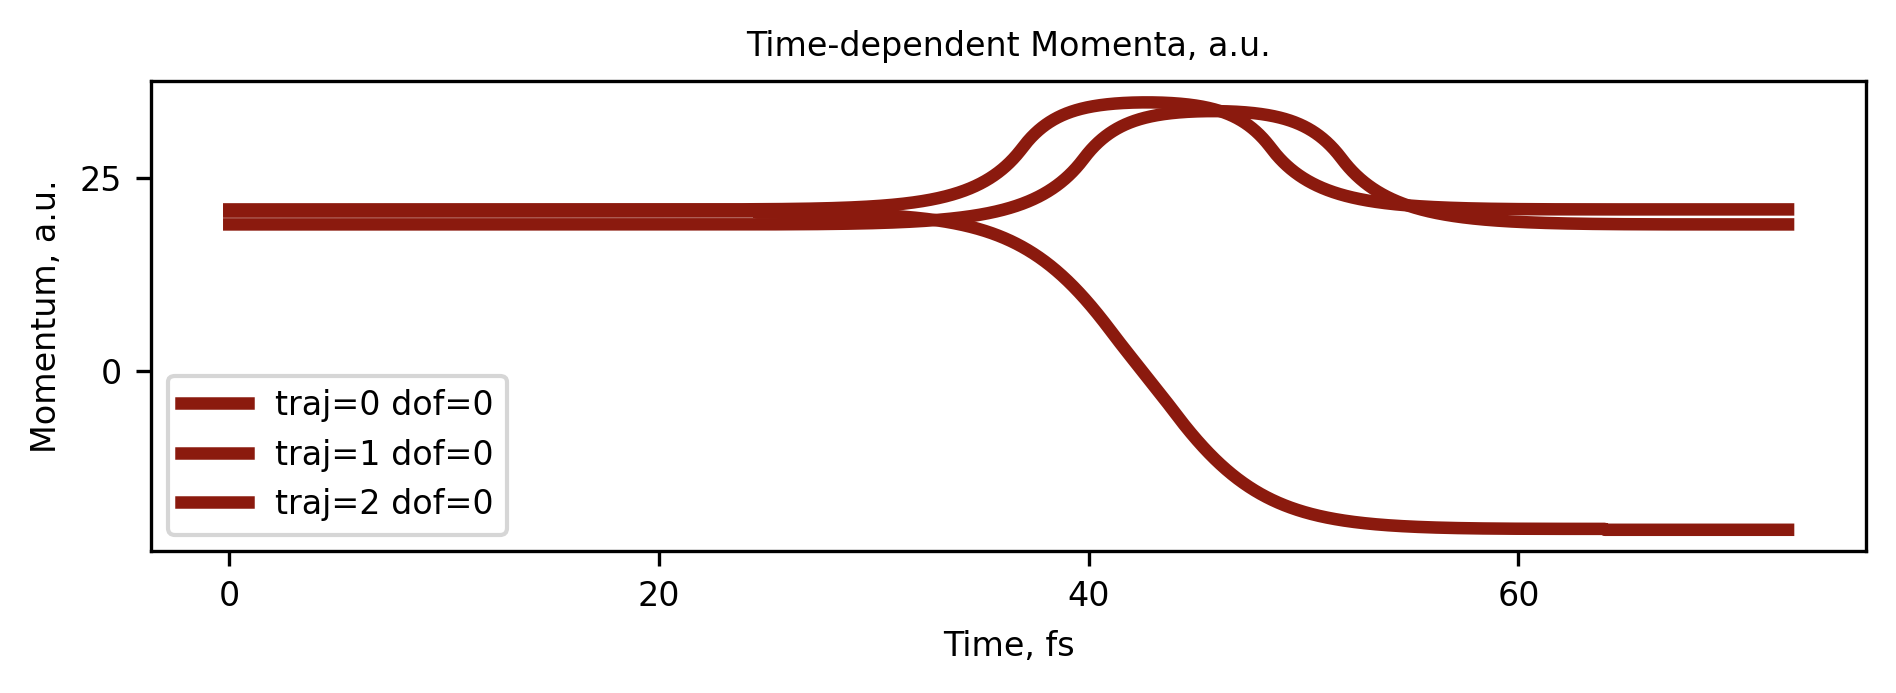

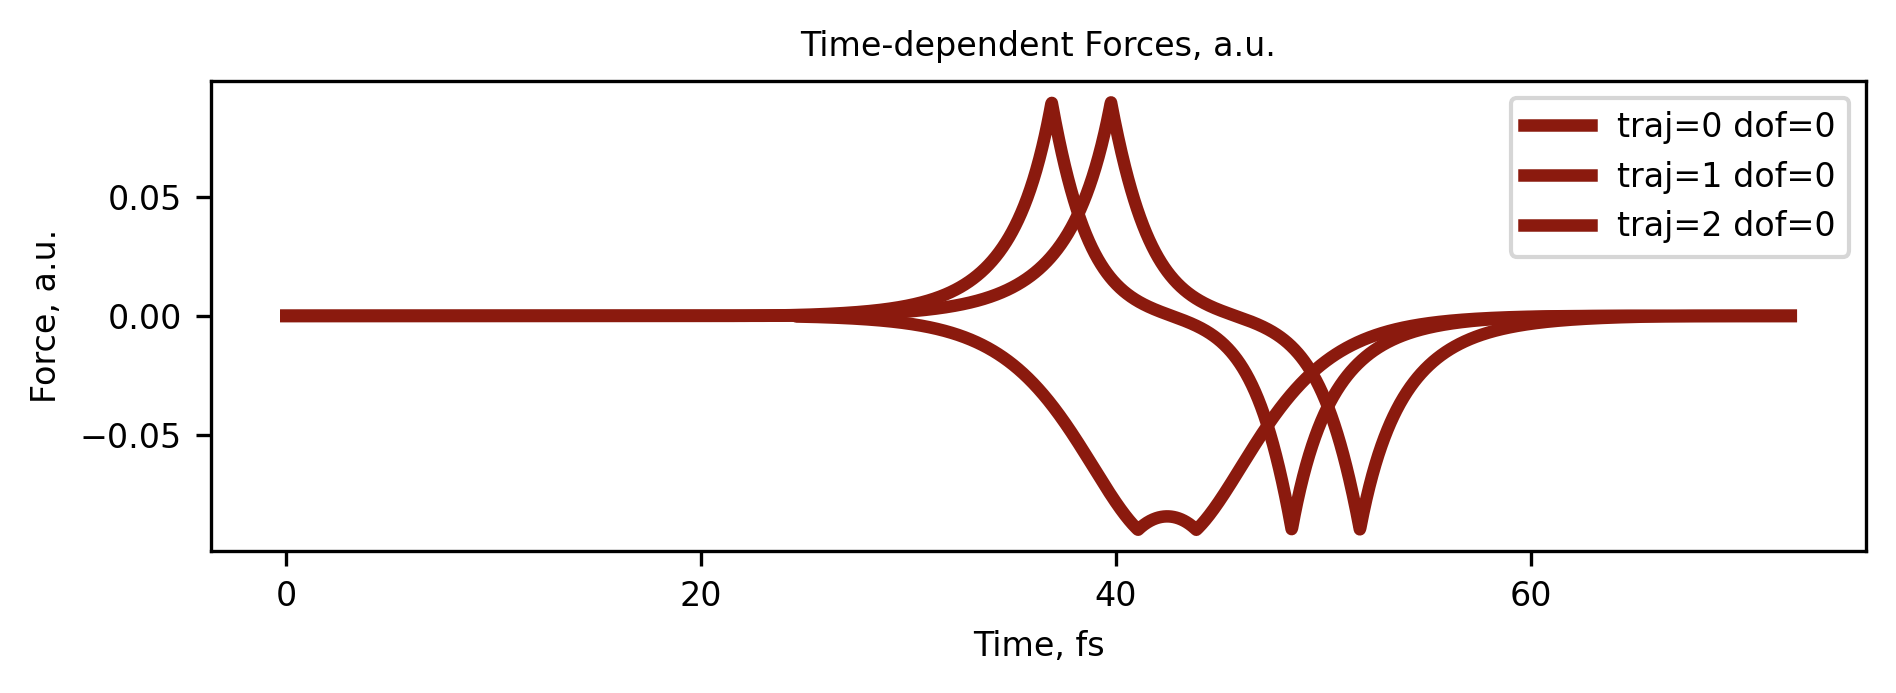

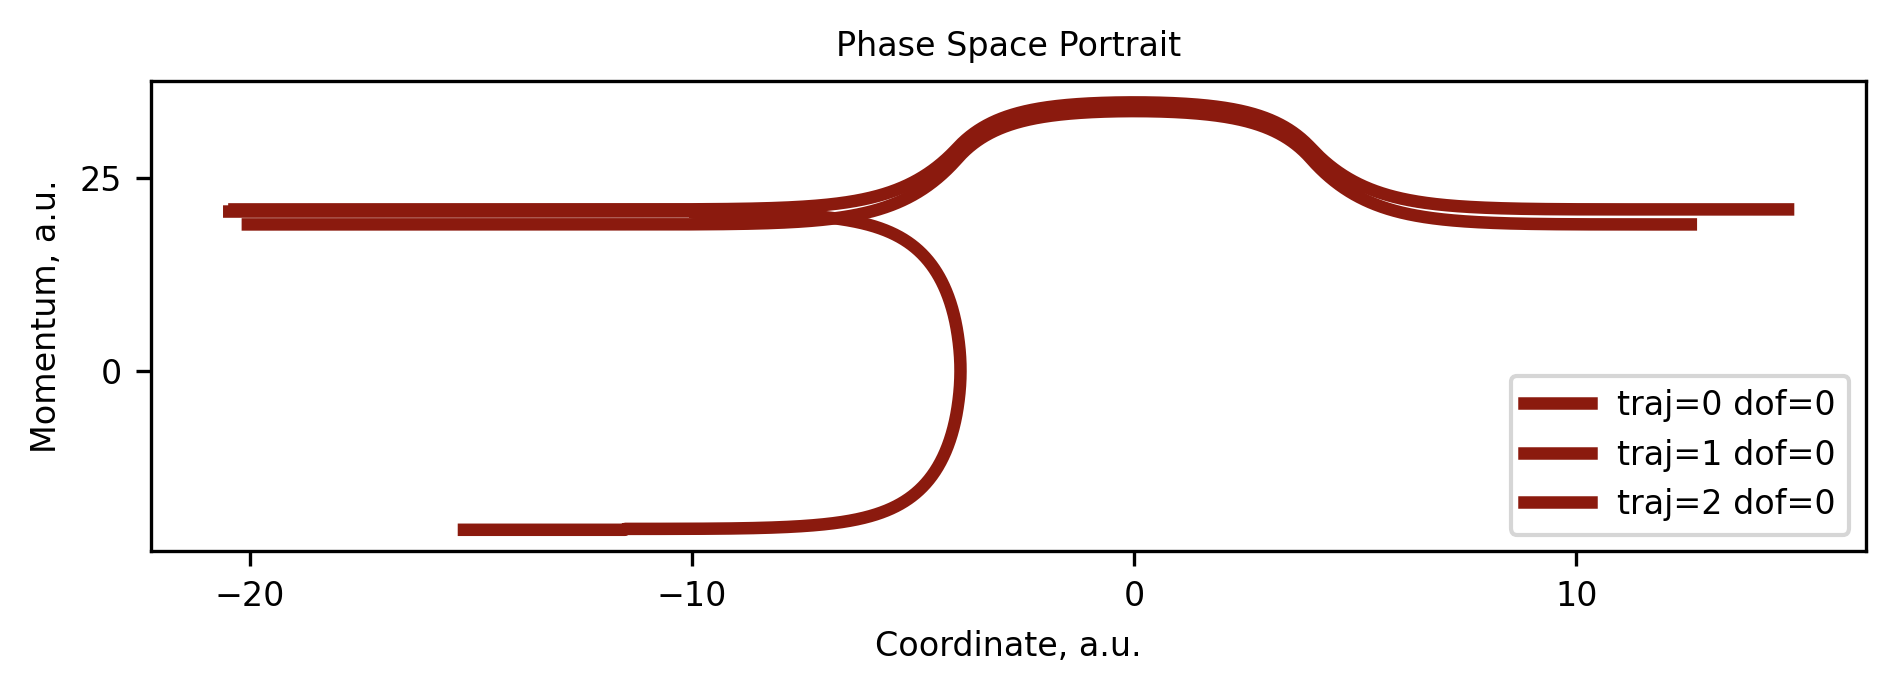

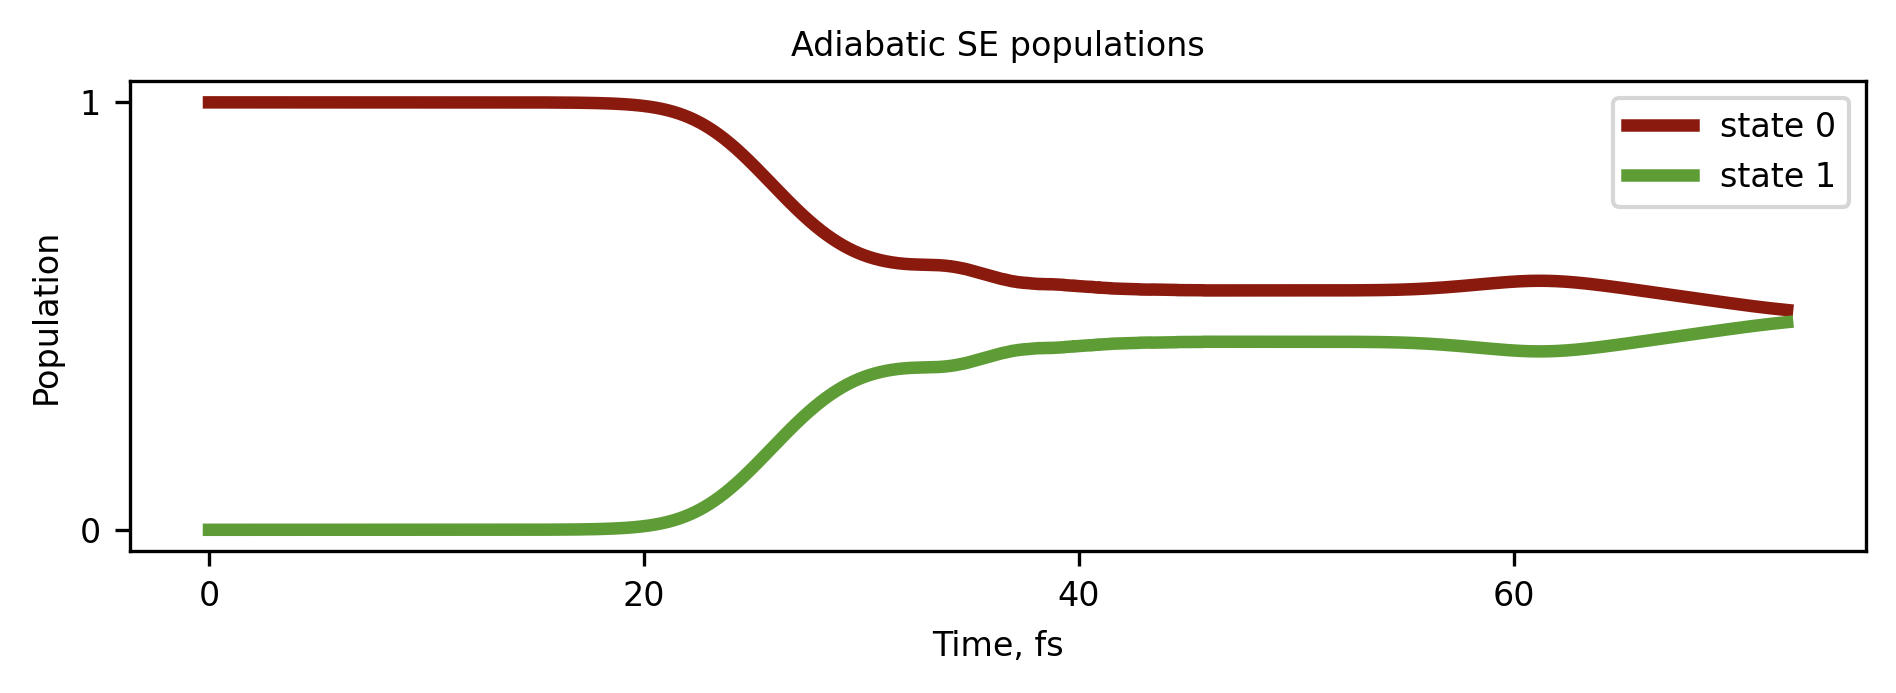

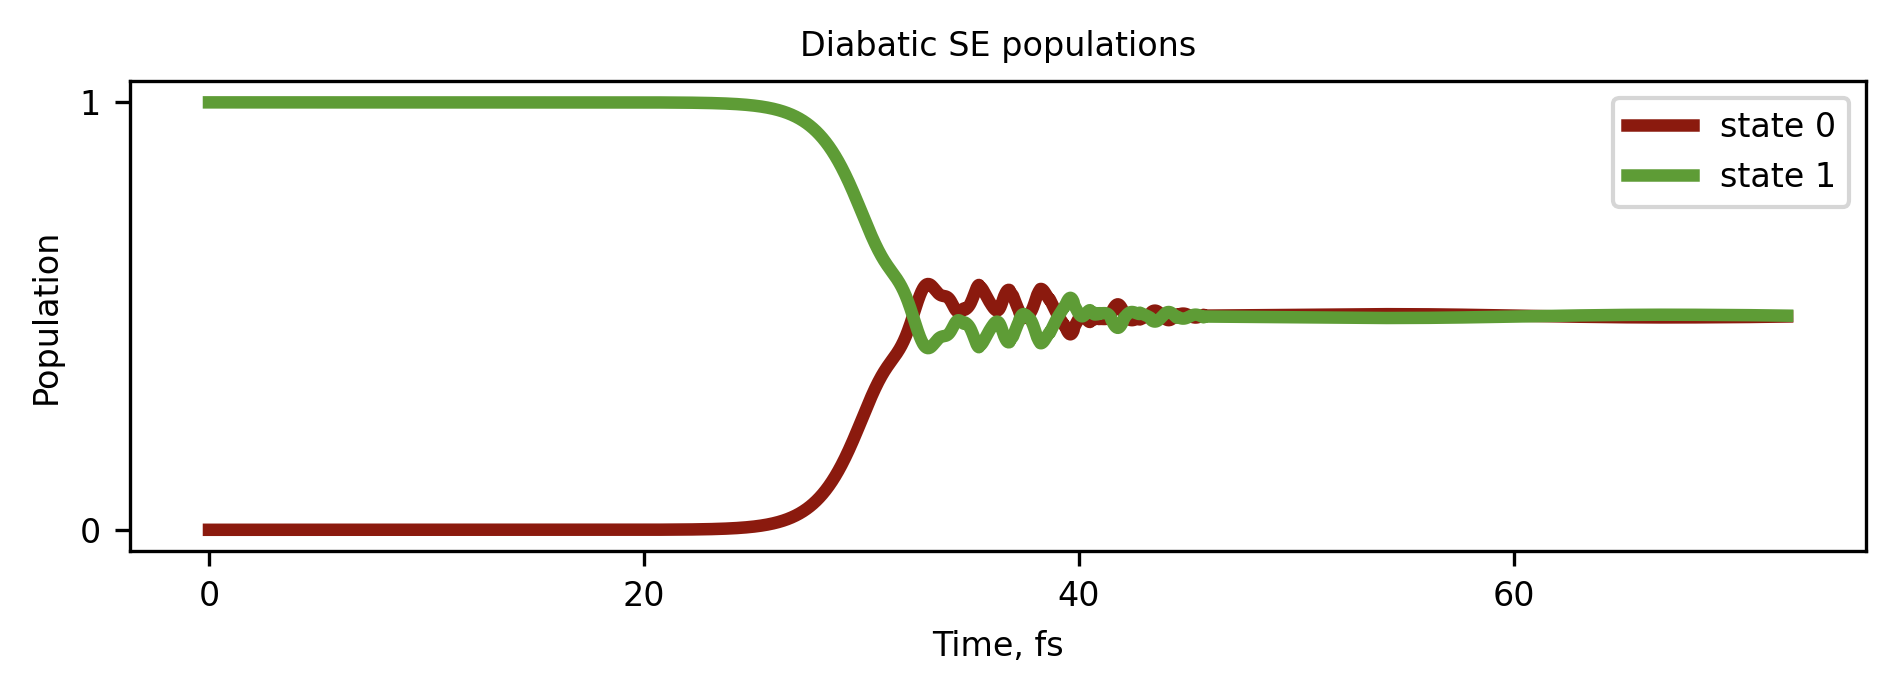

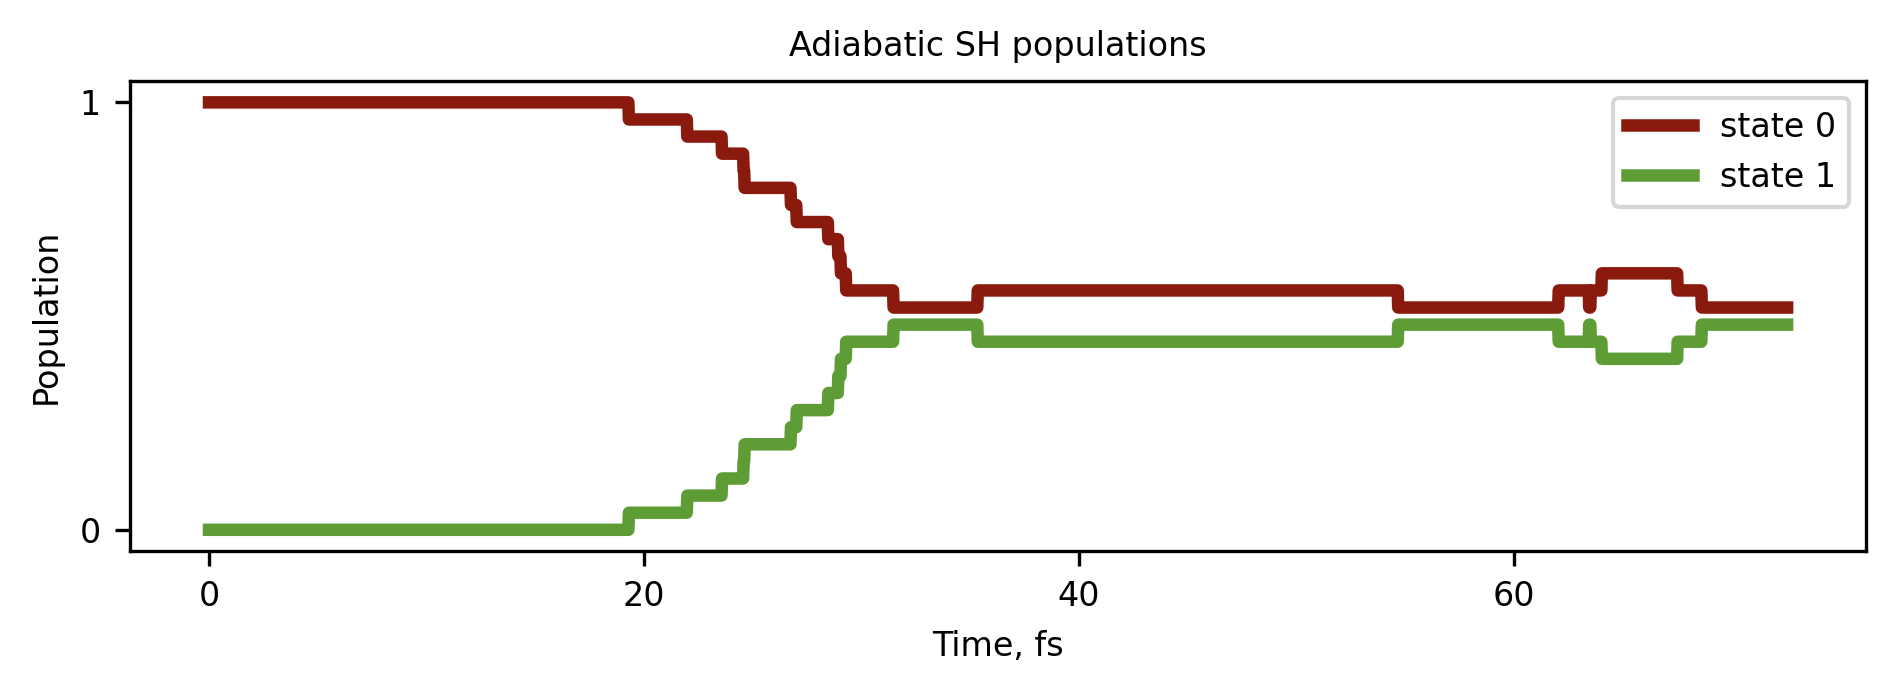

In [12]:
#============ Plotting ==================
pref = F"model{model_indx}-method{method_indx}-icond{icond_indx}"

plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[0, 1, 2], "which_dofs":[0], "which_adi_states":list(range(NSTATES)), 
                "which_dia_states":list(range(NSTATES)), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                                "se_pop_dia", "sh_pop_adi" ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

#"what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
#                                "se_pop_dia", "sh_pop_adi", "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham", 
#                                "time_overlaps", "basis_transform"
#                               ], 

tsh_dynamics_plot.plot_dynamics(plot_params)

## 8. Comparison with quantum dynamics
<a name="8"></a>[Back to TOC](#TOC)

In [13]:
# For setting the initial state
state_indx = [i for i in range(len(elec_params["istates"])) if elec_params["istates"][i] > 0.5][0]


def potential(q, params):
    full_id = Py2Cpp_int([0,0]) 
    
    return compute_model(q, params, full_id)

In [14]:
exact_params = { "nsteps":list_nsteps[model_indx], "dt":1.0, "progress_frequency":1.0/2500,
                 "rmin":[-25.0], "rmax":[25.0], "dx":[0.025], "nstates":2,
                  "x0":nucl_params["q"], "p0":nucl_params["p"], "istate":[1,state_indx], "masses":[2000.0], "k":[0.001],
                  "integrator":"SOFT",
                  "mem_output_level":0, "txt_output_level":0, "txt2_output_level":0, "hdf5_output_level":2, 
                  "properties_to_save":[ "timestep", "time", "Epot_dia", "Ekin_dia", "Etot_dia",
                                         "Epot_adi", "Ekin_adi", "Etot_adi", "norm_dia", "norm_adi",
                                         "pop_dia", "pop_adi", "q_dia", "q_adi", "p_dia", "p_adi" ],
                  "prefix":F"exact-method{method_indx}-icond{icond_indx}", "prefix2":F"exact-method{method_indx}-icond{icond_indx}",
                  "use_compression":0, "compression_level":[0, 0, 0]
               }

wfc = dvr.init_wfc(exact_params, potential, model_params)
savers = dvr_save.init_tsh_savers(exact_params, model_params, exact_params["nsteps"], wfc)
dvr.run_dynamics(wfc, exact_params, model_params, savers)

Dimension 0 has 2048 grid points
Grid size is calculated
Minimal wavevector along dimension 0 is -20.000000
Lower wavevectors are computed 
nstates = 2
ndof = 1
Dimension 0 has 2048 grid points
Norm (dia) =  1.0000000000000002
Norm (adi) =  1.0
Ekin (dia) =  0.1001767766960692
Ekin (adi) =  0.10017677669529566
Epot (dia) =  -0.0006000000045838868
Epot (adi) =  -0.0006000000045838868
HDF5 saver is initialized...
the datasets that can be saved are: ['timestep', 'time', 'Epot_dia', 'Ekin_dia', 'Etot_dia', 'Epot_adi', 'Ekin_adi', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']
 step= 0
 step= 1
 step= 2
 step= 3
 step= 4
 step= 5
 step= 6
 step= 7
 step= 8
 step= 9
 step= 10
 step= 11
 step= 12
 step= 13
 step= 14
 step= 15
 step= 16
 step= 17
 step= 18
 step= 19
 step= 20
 step= 21
 step= 22
 step= 23
 step= 24
 step= 25
 step= 26
 step= 27
 step= 28
 step= 29
 step= 30
 step= 31
 step= 32
 step= 33
 step= 34
 step= 35
 step= 36
 step= 37
 ste

 step= 509
 step= 510
 step= 511
 step= 512
 step= 513
 step= 514
 step= 515
 step= 516
 step= 517
 step= 518
 step= 519
 step= 520
 step= 521
 step= 522
 step= 523
 step= 524
 step= 525
 step= 526
 step= 527
 step= 528
 step= 529
 step= 530
 step= 531
 step= 532
 step= 533
 step= 534
 step= 535
 step= 536
 step= 537
 step= 538
 step= 539
 step= 540
 step= 541
 step= 542
 step= 543
 step= 544
 step= 545
 step= 546
 step= 547
 step= 548
 step= 549
 step= 550
 step= 551
 step= 552
 step= 553
 step= 554
 step= 555
 step= 556
 step= 557
 step= 558
 step= 559
 step= 560
 step= 561
 step= 562
 step= 563
 step= 564
 step= 565
 step= 566
 step= 567
 step= 568
 step= 569
 step= 570
 step= 571
 step= 572
 step= 573
 step= 574
 step= 575
 step= 576
 step= 577
 step= 578
 step= 579
 step= 580
 step= 581
 step= 582
 step= 583
 step= 584
 step= 585
 step= 586
 step= 587
 step= 588
 step= 589
 step= 590
 step= 591
 step= 592
 step= 593
 step= 594
 step= 595
 step= 596
 step= 597
 step= 598
 step= 599

 step= 1234
 step= 1235
 step= 1236
 step= 1237
 step= 1238
 step= 1239
 step= 1240
 step= 1241
 step= 1242
 step= 1243
 step= 1244
 step= 1245
 step= 1246
 step= 1247
 step= 1248
 step= 1249
 step= 1250
 step= 1251
 step= 1252
 step= 1253
 step= 1254
 step= 1255
 step= 1256
 step= 1257
 step= 1258
 step= 1259
 step= 1260
 step= 1261
 step= 1262
 step= 1263
 step= 1264
 step= 1265
 step= 1266
 step= 1267
 step= 1268
 step= 1269
 step= 1270
 step= 1271
 step= 1272
 step= 1273
 step= 1274
 step= 1275
 step= 1276
 step= 1277
 step= 1278
 step= 1279
 step= 1280
 step= 1281
 step= 1282
 step= 1283
 step= 1284
 step= 1285
 step= 1286
 step= 1287
 step= 1288
 step= 1289
 step= 1290
 step= 1291
 step= 1292
 step= 1293
 step= 1294
 step= 1295
 step= 1296
 step= 1297
 step= 1298
 step= 1299
 step= 1300
 step= 1301
 step= 1302
 step= 1303
 step= 1304
 step= 1305
 step= 1306
 step= 1307
 step= 1308
 step= 1309
 step= 1310
 step= 1311
 step= 1312
 step= 1313
 step= 1314
 step= 1315
 step= 1316
 ste

 step= 1919
 step= 1920
 step= 1921
 step= 1922
 step= 1923
 step= 1924
 step= 1925
 step= 1926
 step= 1927
 step= 1928
 step= 1929
 step= 1930
 step= 1931
 step= 1932
 step= 1933
 step= 1934
 step= 1935
 step= 1936
 step= 1937
 step= 1938
 step= 1939
 step= 1940
 step= 1941
 step= 1942
 step= 1943
 step= 1944
 step= 1945
 step= 1946
 step= 1947
 step= 1948
 step= 1949
 step= 1950
 step= 1951
 step= 1952
 step= 1953
 step= 1954
 step= 1955
 step= 1956
 step= 1957
 step= 1958
 step= 1959
 step= 1960
 step= 1961
 step= 1962
 step= 1963
 step= 1964
 step= 1965
 step= 1966
 step= 1967
 step= 1968
 step= 1969
 step= 1970
 step= 1971
 step= 1972
 step= 1973
 step= 1974
 step= 1975
 step= 1976
 step= 1977
 step= 1978
 step= 1979
 step= 1980
 step= 1981
 step= 1982
 step= 1983
 step= 1984
 step= 1985
 step= 1986
 step= 1987
 step= 1988
 step= 1989
 step= 1990
 step= 1991
 step= 1992
 step= 1993
 step= 1994
 step= 1995
 step= 1996
 step= 1997
 step= 1998
 step= 1999
 step= 2000
 step= 2001
 ste

 step= 2604
 step= 2605
 step= 2606
 step= 2607
 step= 2608
 step= 2609
 step= 2610
 step= 2611
 step= 2612
 step= 2613
 step= 2614
 step= 2615
 step= 2616
 step= 2617
 step= 2618
 step= 2619
 step= 2620
 step= 2621
 step= 2622
 step= 2623
 step= 2624
 step= 2625
 step= 2626
 step= 2627
 step= 2628
 step= 2629
 step= 2630
 step= 2631
 step= 2632
 step= 2633
 step= 2634
 step= 2635
 step= 2636
 step= 2637
 step= 2638
 step= 2639
 step= 2640
 step= 2641
 step= 2642
 step= 2643
 step= 2644
 step= 2645
 step= 2646
 step= 2647
 step= 2648
 step= 2649
 step= 2650
 step= 2651
 step= 2652
 step= 2653
 step= 2654
 step= 2655
 step= 2656
 step= 2657
 step= 2658
 step= 2659
 step= 2660
 step= 2661
 step= 2662
 step= 2663
 step= 2664
 step= 2665
 step= 2666
 step= 2667
 step= 2668
 step= 2669
 step= 2670
 step= 2671
 step= 2672
 step= 2673
 step= 2674
 step= 2675
 step= 2676
 step= 2677
 step= 2678
 step= 2679
 step= 2680
 step= 2681
 step= 2682
 step= 2683
 step= 2684
 step= 2685
 step= 2686
 ste

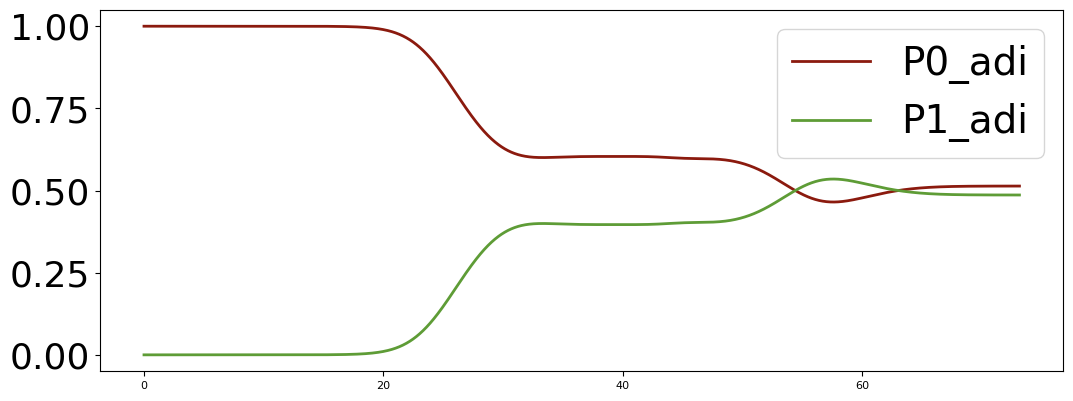

In [15]:
plt.figure(figsize=(2*6.42, 2*2.41))
plt.xticks(fontsize=8)
with h5py.File(F"exact-method{method_indx}-icond{icond_indx}/data.hdf", 'r') as f:        
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 0, 0], label="P0_adi", linewidth=2, color = colors["11"])
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 1, 0], label="P1_adi", linewidth=2, color = colors["21"])
    plt.legend()